In [1]:
import os
import tensorflow as tf
import cv2
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import gc

In [2]:
data_dir="/kaggle/input/tomato-plant-disease/Tomato-dataset"
class_names = ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Mosaic_virus', 'Tomato_Septoria_leafspot', 'Tomato_Spider_mites', 'Tomato_Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus']
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)

In [3]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img

# Define the Generator model
def build_generator(noise_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(1024, activation='relu', input_dim=noise_dim))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(9000, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256*256*3, activation='tanh'))
    model.add(layers.Reshape((256, 256, 3)))
    return model

# Define the Discriminator model
def build_discriminator(image_shape):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, input_shape=image_shape, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Combine Generator and Discriminator to create the GAN model
def build_gan(generator, discriminator):
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    gan_input = layers.Input(shape=(500,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)
    gan = tf.keras.models.Model(gan_input, gan_output)
    gan.compile(optimizer='adam', loss='binary_crossentropy')
    return gan

# Save the model after every 5 epochs
def save_model(generator, discriminator, gan, epoch):
    print(f'Saving model for epoch: {epoch}')
    generator.save(f'gan_checkpoints/generator_epoch_{epoch}.keras')
    discriminator.save(f'gan_checkpoints/discriminator_epoch_{epoch}.keras')

# Load models if they exist
def load_last_checkpoint():
    checkpoint_dir = 'gan_checkpoints'
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
        return None, 0  # Return None and start from epoch 0

    # Get the latest checkpoint
    checkpoints = [int(f.split('_')[2].split('.')[0]) for f in os.listdir(checkpoint_dir) if f.startswith('generator_epoch')]
    if checkpoints:
        last_epoch = max(checkpoints)
        print(f"Resuming from epoch {last_epoch}")
        generator = tf.keras.models.load_model(f'{checkpoint_dir}/generator_epoch_{last_epoch}.keras')
        discriminator = tf.keras.models.load_model(f'{checkpoint_dir}/discriminator_epoch_{last_epoch}.keras')
        return (generator, discriminator), last_epoch + 1
    else:
        return None, 0  # No checkpoints found, start from epoch 0

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(256, 256),
    batch_size=64,
    shuffle=True)
dataset = dataset.take(len(dataset)//25).cache()
dataset = dataset.map(lambda x, y: (x/255.0, y))
dataset = dataset.prefetch(tf.data.AUTOTUNE)
num_classes = len(class_names)
image_shape = (256, 256, 3)
noise_dim = 500
generator = None
discriminator = None
gan = None
# Training function for the GAN
def train_gan(dataset, epochs=10000, batch_size=32, sample_interval=200):
    # Load the models or start from scratch
    global generator
    global discriminator
    global gan
    models, starting_epoch = load_last_checkpoint()
    if models is None:
        generator = build_generator(noise_dim)
        discriminator = build_discriminator(image_shape)
    else:
        generator, discriminator = models
    gan = build_gan(generator, discriminator)

    half_batch = int(batch_size / 2)
    
    for epoch in range(starting_epoch, epochs):
        print(f"Epoch {epoch}/{epochs}")
        #save_generated_images(epoch)
        for real_images, _ in dataset:
            # Train Discriminator
            idx = np.random.randint(0, real_images.shape[0], half_batch)
            real_imgs = tf.gather(real_images, idx)
            noise = np.random.normal(0, 1, (half_batch, noise_dim))
            generated_imgs = generator.predict(noise)

            real_labels = np.ones((half_batch, 1))
            fake_labels = np.zeros((half_batch, 1))
            real_labels = np.ones((half_batch, 1)) * 0.9  # Label smoothing
            fake_labels = np.zeros((half_batch, 1)) + 0.1

            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch(real_imgs, real_labels)
            d_loss_fake = discriminator.train_on_batch(generated_imgs, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            valid_labels = np.ones((batch_size, 1))
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, valid_labels)
            # Clear unused variables and free up memory
            del real_imgs, generated_imgs, noise
            gc.collect()
        print(f"{epoch}: D Loss: {d_loss[0]}, G Loss: {g_loss}")
        # Save generated images at the sample interval
        if epoch > epochs/2 and epoch % sample_interval == 0:
            save_generated_images(epoch)

        # Save the model every 5 epochs
        if epoch % 3 == 0:
            save_model(generator, discriminator, gan, epoch)

        # Clear unused memory at the end of each epoch
        gc.collect()

        # Clear Keras session to prevent memory build-up every few epochs
        if epoch % 2 == 0:
            tf.keras.backend.clear_session()

# Save the generated images to disk
def save_generated_images(epoch, num_samples_per_class=10):
    print('Saving Generated Images')
    output_dir = 'gan_generated_images'
    os.makedirs(output_dir, exist_ok=True)

    # Generate images in smaller batches to reduce memory usage
    for _, class_name in enumerate(class_names):
        class_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        for _ in range(num_samples_per_class):
            noise = tf.random.normal((1, noise_dim))
            generated_image = generator.predict(noise)
            generated_image = 0.5 * generated_image + 0.5  # Rescale to [0, 1]

            # Convert to image and save
            img = array_to_img(generated_image[0])
            img.save(os.path.join(class_dir, f"{class_name}_{epoch}.png"))

        # Force garbage collection after saving images
        gc.collect()

Found 41800 files belonging to 10 classes.


In [6]:
# Train the GAN
train_gan(dataset, epochs=2200, batch_size=64, sample_interval=5)

Epoch 2192/2200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2192: D Loss: 0.6103204727172852, G Loss: 0.6139866828918457
Epoch 2193/2200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms

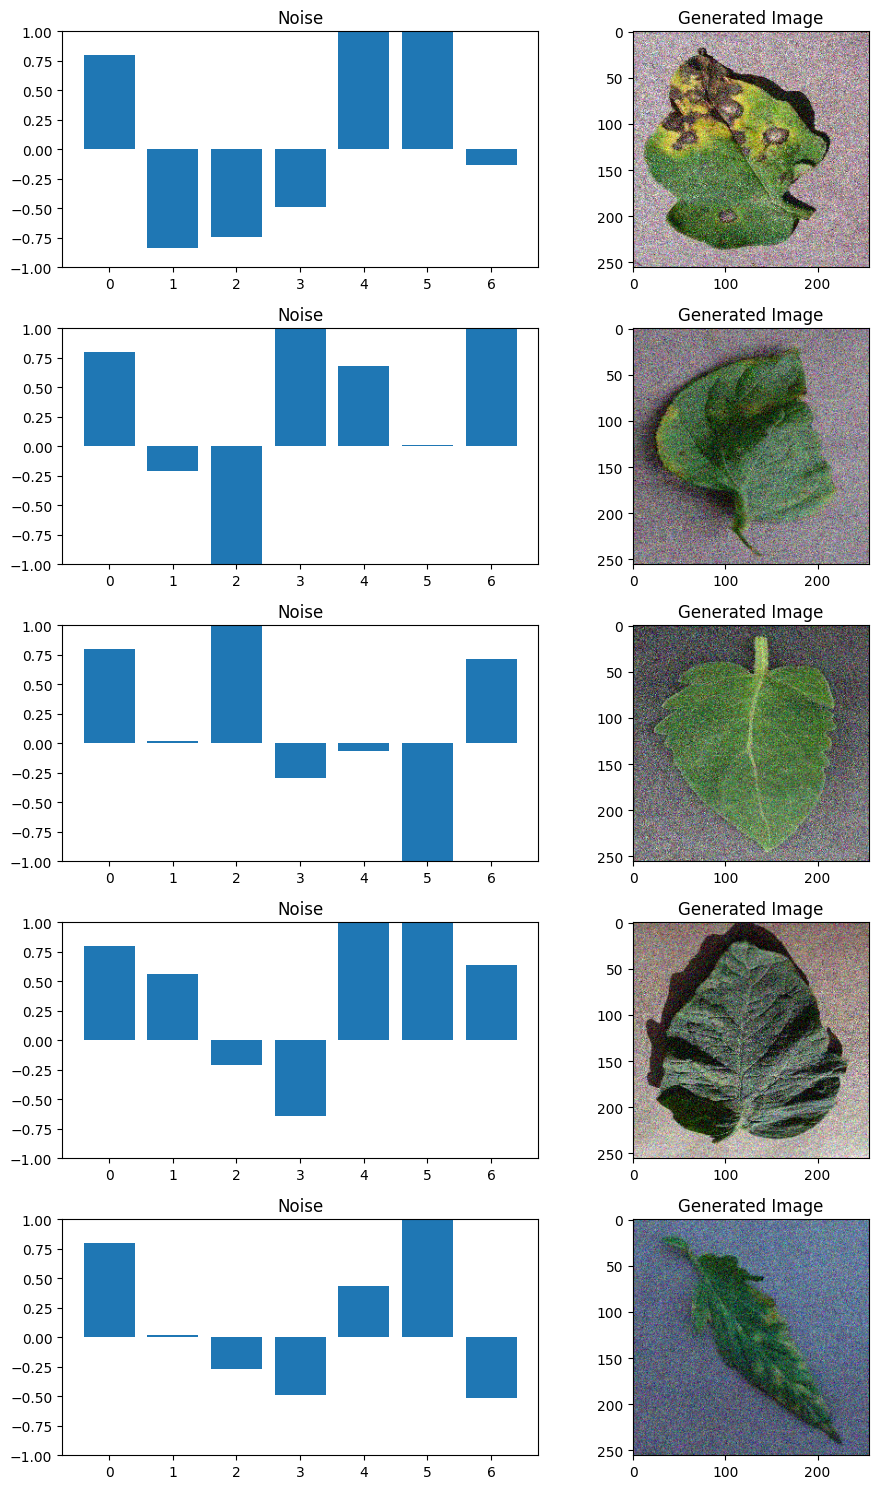

In [29]:
def plot_images_with_noise(num_images=5):
    plt.figure(figsize=(15, 3 * num_images))
    
    for i in range(num_images):
        noise = tf.tensor_scatter_nd_update(tf.random.normal([500]), [[0]], [0.8])
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.bar(np.arange(7), noise[:7].numpy())
        plt.ylim([-1, 1])
        plt.title(f"Noise")
        
        # Plot the noise vector as a bar chart
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(tf.squeeze(generator.predict(tf.expand_dims(noise, axis = 0)))) 
        plt.title(f"Generated Image")
    
    plt.tight_layout()
    plt.show()
plot_images_with_noise()

In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

# Function to apply augmentation to a dataset
def augment_data(dataset):
    return dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

In [5]:
class_names = ['Tomato_Spider_mites', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_Late_blight', 'Tomato_Early_blight', 'Tomato_Mosaic_virus', 'Tomato_Septoria_leafspot', 'Tomato_Bacterial_spot', 'Tomato_Healthy', 'Tomato_Target_Spot', 'Tomato_Leaf_Mold']
data = tf.keras.utils.image_dataset_from_directory('/kaggle/working/generated_images', batch_size = None, class_names=class_names)

train_size = 0.7
val_size = 0.15
test_size = 0.15

dataset_size = len(data)
train_samples = int(train_size * dataset_size)
val_samples = int(val_size * dataset_size)
test_samples = dataset_size - train_samples - val_samples

data = data.shuffle(buffer_size=512, seed=42)

train_dataset = data.take(train_samples)
val_dataset = data.skip(train_samples).take(val_samples)
test_dataset = data.skip(train_samples + val_samples)

train_dataset_aug = augment_data(train_dataset)

# Combine the original and augmented datasets
train_dataset = train_dataset.concatenate(train_dataset_aug)

# Shuffle and prepare the dataset
train_dataset = train_dataset.shuffle(buffer_size=128, seed=42)
train_dataset = train_dataset.take(len(train_dataset) // 2)

Found 20903 files belonging to 10 classes.


In [6]:
train_dataset = train_dataset.map(lambda x,y: (x/255, y))
train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(lambda x,y: (x/255, y))
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(lambda x,y: (x/255, y))
test_dataset = test_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

In [4]:
def build_cnn() :
  input_shape=(256,256,3)
  num_classes=10

  model=Sequential()
  model.add(Conv2D(32, (3, 3), activation="relu", input_shape=input_shape))
  model.add(MaxPooling2D())
  model.add(Dropout(0.3))

  model.add(Conv2D(64, (3, 3), activation="relu"))
  model.add(MaxPooling2D())
  model.add(Dropout(0.3))

  model.add(Conv2D(128, (3, 3), activation="relu"))
  model.add(MaxPooling2D())
  model.add(Dropout(0.3))

  model.add(Conv2D(256, (3, 3), activation="relu"))
  model.add(MaxPooling2D())
  model.add(Dropout(0.3))

  model.add(Conv2D(512, (3, 3), activation="relu"))
  model.add(MaxPooling2D())
  model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(Dense(256, activation="relu", kernel_regularizer=l2(0.001)))
  model.add(Dropout(0.5))
  model.add(Dense(128, activation="relu", kernel_regularizer=l2(0.001)))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation="softmax", kernel_regularizer=l2(0.001)))

  model.compile(
      optimizer="adam",
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=["accuracy"]
  )
  #model.summary()
  return model
model = build_cnn()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',        # Where to save the model
    monitor='val_loss',              # What to monitor (you can change it to 'loss' for training loss)
    mode='min',                      # Mode 'min' because we want to minimize the loss
    verbose=1                        # Print info when saving the model
)
history = model.fit(
    train_dataset,
    epochs=35,
    validation_data=val_dataset,
    callbacks=[checkpoint_callback]
)

Epoch 1/35


I0000 00:00:1728974365.220357     502 service.cc:145] XLA service 0x7b7c34010e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728974365.220438     502 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/229 ━━━━━━━━━━━━━━━━━━━━ 1:22:34 22s/step - accuracy: 0.1562 - loss: 2.9761

I0000 00:00:1728974383.338538     502 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_1', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1728974383.356234     502 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.2022 - loss: 2.6797

I0000 00:00:1728974419.643434     502 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_1', 4 bytes spill stores, 12 bytes spill loads




Epoch 1: saving model to best_model.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 79s 253ms/step - accuracy: 0.2024 - loss: 2.6784 - val_accuracy: 0.3678 - val_loss: 2.0475
Epoch 2/35
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3537 - loss: 1.9367
Epoch 2: saving model to best_model.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 43s 186ms/step - accuracy: 0.3538 - loss: 1.9363 - val_accuracy: 0.4957 - val_loss: 1.6540
Epoch 3/35
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5292 - loss: 1.5011
Epoch 3: saving model to best_model.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.5293 - loss: 1.5007 - val_accuracy: 0.6348 - val_loss: 1.1823
Epoch 4/35
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6505 - loss: 1.1931
Epoch 4: saving model to best_model.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 40s 173ms/step - accuracy: 0.6506 - loss: 1.1929 - val_accuracy: 0.7614 - val_loss: 0.9203
Epoch 5/35
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7275 - loss: 0.9836
Epo

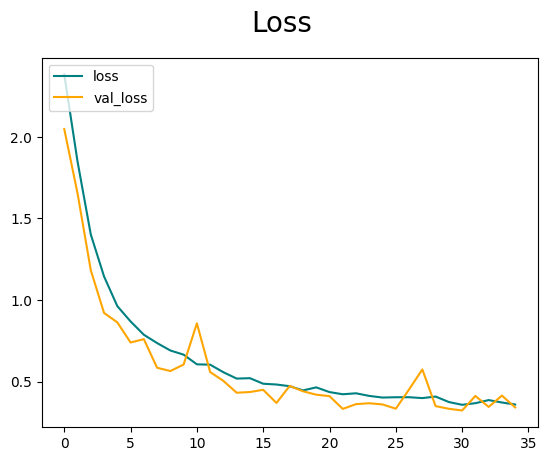

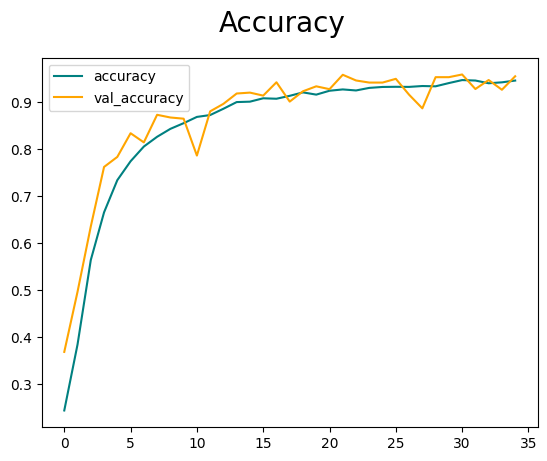

In [18]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [19]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.9470 - loss: 0.3612
Test accuracy: 0.9413265585899353
Test loss: 0.3699416220188141


# Applying Segmentation

In [ ]:
from PIL import Image

unet = tf.keras.models.load_model('/kaggle/input/unet_teresha/keras/default/1/best_unet_model (1).keras')

output_dir = 'masked_images'
os.makedirs(output_dir, exist_ok=True)

data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size=128)
data_gen = tf.keras.utils.image_dataset_from_directory('/kaggle/working/generated_images', batch_size=128)
data = data.concatenate(data_gen)

data = data.map(lambda x, y: (x / 255, y))  # Normalize the images and keep the labels
data = data.prefetch(tf.data.AUTOTUNE)

# Iterate through the batches of data and generate predictions
for i, (batch, labels) in enumerate(data):
    # Get the model's predictions
    predictions = unet.predict(batch)

    # Post-process the predictions (convert from float [0,1] to uint8 [0,255])
    predictions = np.clip(predictions * 255, 0, 255).astype(np.uint8)

    # Iterate through the batch and save each image
    for j in range(predictions.shape[0]):
        img = predictions[j]
        img = Image.fromarray(img)

        # Get the class name for the current label
        class_name = class_names[labels[j]]

        # Define the directory to save the image
        class_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        # Define the file path to save the image
        file_path = os.path.join(class_dir, f'masked_image_{i}_{j}.png')
        img.save(file_path)

print(f"Images saved in {output_dir}")

In [25]:
data = tf.keras.utils.image_dataset_from_directory('masked_images', batch_size = None)

train_size = 0.7
val_size = 0.15
test_size = 0.15

dataset_size = len(data)
train_samples = int(train_size * dataset_size)
val_samples = int(val_size * dataset_size)
test_samples = dataset_size - train_samples - val_samples

data = data.shuffle(buffer_size=512, seed=42)

train_dataset = data.take(train_samples)
val_dataset = data.skip(train_samples).take(val_samples)
test_dataset = data.skip(train_samples + val_samples)

train_dataset_aug = augment_data(train_dataset)
train_dataset = train_dataset.concatenate(train_dataset_aug)
train_dataset = train_dataset.shuffle(buffer_size=512, seed=42)
train_dataset = train_dataset.take(len(train_dataset)//9)

Found 62703 files belonging to 10 classes.


In [26]:
train_dataset = train_dataset.map(lambda x,y: (x/255, y))
train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(lambda x,y: (x/255, y))
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(lambda x,y: (x/255, y))
test_dataset = test_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

In [28]:
model = build_cnn()

In [54]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_gen_segmented_cnn.keras',        # Where to save the model
    monitor='val_loss',              # What to monitor (you can change it to 'loss' for training loss)
    mode='min',                      # Mode 'min' because we want to minimize the loss
    verbose=1                        # Print info when saving the model
)
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=val_dataset,
    #callbacks=[checkpoint_callback]
)

Epoch 1/25
153/153 ━━━━━━━━━━━━━━━━━━━━━━━ 51s 331ms/step - accuracy: 0.2452 - loss: 2.5606 - val_accuracy: 0.3562 - val_loss: 2.0377
Epoch 2/25
153/153 ━━━━━━━━━━━━━━━━━━━━━━━ 51s 331ms/step - accuracy: 0.4326 - loss: 1.7873 - val_accuracy: 0.5540 - val_loss: 1.6093
Epoch 3/25
153/153 ━━━━━━━━━━━━━━━━━━━━━━━ 51s 331ms/step - accuracy: 0.5294 - loss: 1.5643 - val_accuracy: 0.4345 - val_loss: 1.8626
Epoch 4/25
153/153 ━━━━━━━━━━━━━━━━━━━━━━━ 51s 331ms/step - accuracy: 0.5627 - loss: 1.5165 - val_accuracy: 0.6246 - val_loss: 1.4847
Epoch 5/25
153/153 ━━━━━━━━━━━━━━━━━━━━━━━ 51s 331ms/step - accuracy: 0.6150 - loss: 1.3893 - val_accuracy: 0.6739 - val_loss: 1.4093
Epoch 6/25
153/153 ━━━━━━━━━━━━━━━━━━━━━━━ 51s 331ms/step - accuracy: 0.6370 - loss: 1.3474 - val_accuracy: 0.7510 - val_loss: 1.2592
Epoch 7/25
153/153 ━━━━━━━━━━━━━━━━━━━━━━━ 51s 331ms/step - accuracy: 0.6855 - loss: 1.2469 - val_accuracy: 0.7130 - val_loss: 1.3807
Epoch 8/25
153/153 ━━━━━━━━━━━━━━━━━━━━━━━ 51s 331ms/step - ac

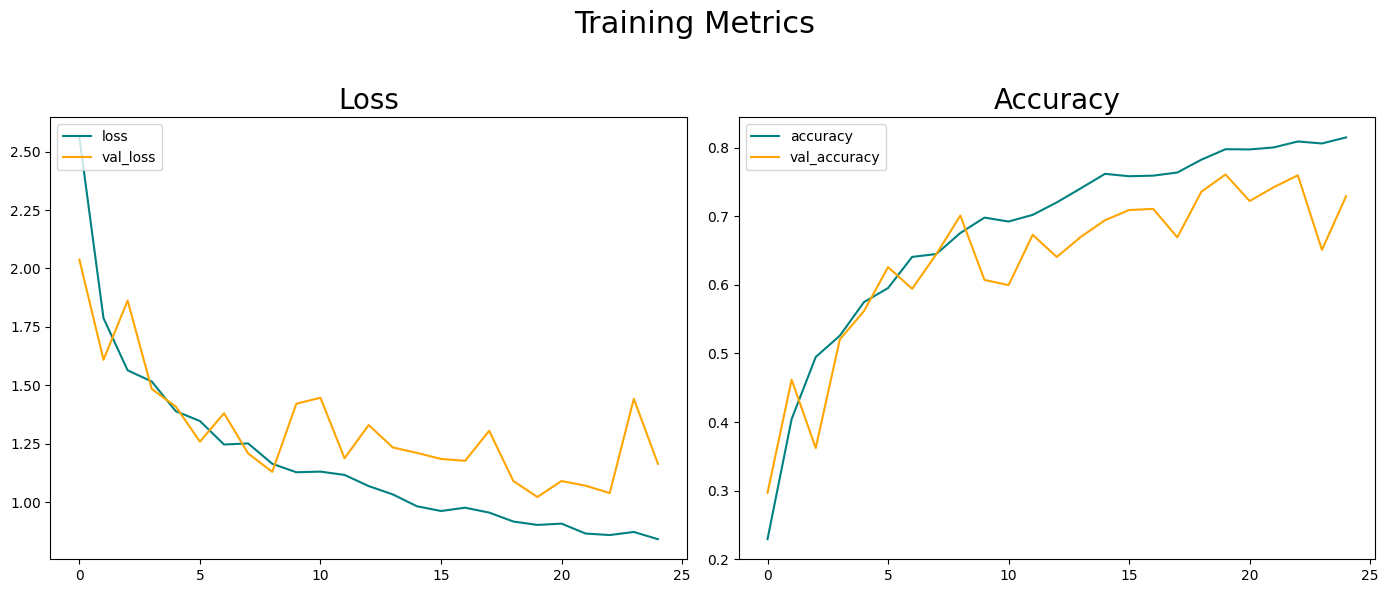

In [59]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [65]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")

Test accuracy: 0.8474080514907837
Test loss: 0.9359675407409669


In [31]:
test_dir = '/kaggle/input/tomato-leaf-disease-test/tomato-disease-test-22/test_imgs/test_imgs/Tomato_Bacterial_spot'
dataset_bs = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),  # Adjust image size according to your segmentation model
    batch_size=None,
    labels=None
)
dataset_bs = dataset_bs.map(lambda x: (x/255, 6))
test_dir = '/kaggle/input/tomato-leaf-disease-test/tomato-disease-test-22/test_imgs/test_imgs/Tomato_Early_blight'
dataset_eb = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),  # Adjust image size according to your segmentation model
    batch_size=None,
    labels=None
)
dataset_eb = dataset_eb.map(lambda x: (x/255, 3))
test_dir = '/kaggle/input/tomato-leaf-disease-test/tomato-disease-test-22/test_imgs/test_imgs/Tomato_Spider_mites'
dataset_sm = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),  # Adjust image size according to your segmentation model
    batch_size=None,
    labels=None
)
dataset_sm = dataset_sm.map(lambda x: (x/255, 0))
test_dataset=dataset_bs.concatenate(dataset_eb).concatenate(dataset_sm)

segmentation_model = tf.keras.models.load_model('/kaggle/input/unet_teresha/keras/default/1/best_unet_model (1).keras')

images = []
labels = []
orig_img = []
for img_batch, label_batch in test_dataset:
    segmentation_mask = segmentation_model.predict(np.expand_dims(img_batch.numpy(), axis=0))
    segmentation_mask = tf.squeeze(segmentation_mask, axis=0)
    orig_img.append(img_batch.numpy())
    images.append(segmentation_mask.numpy())
    labels.append(label_batch.numpy())

# Concatenate the lists into NumPy arrays
test_images_np = np.array(images)  # Shape (num_samples, 256, 256, 3)
test_labels_np = np.array(labels)  # Shape (num_samples,)
orig_img_np = np.array(orig_img)

Found 2 files.
Found 2 files.
Found 2 files.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [32]:
model = tf.keras.models.load_model('/kaggle/working/best_gen_segmented_cnn.keras')
test_labels_preds = model.predict(test_images_np)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


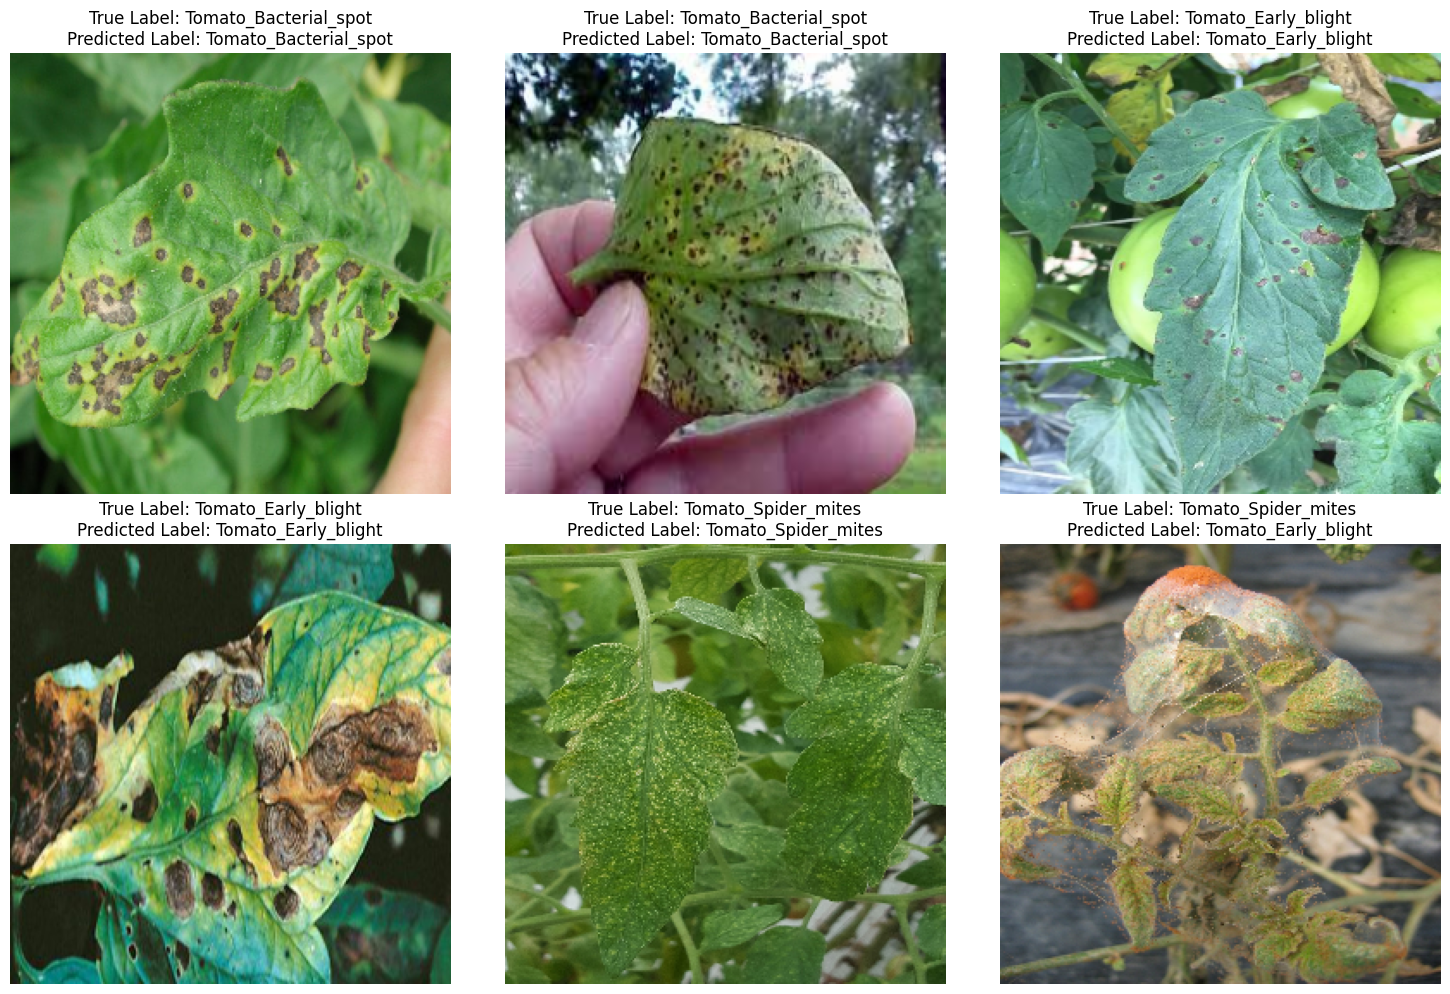

In [34]:
def display_images(true_labels, pred_labels, cols=3, figsize=(15, 10)):
    rows = 2
    plt.figure(figsize=figsize)
    
    for i, image in enumerate(orig_img):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.title(f'True Label: {class_names[true_labels[i]]}\nPredicted Label: {class_names[pred_labels[i].argmax()]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

display_images(test_labels_np, test_labels_preds)